# GOFevaluation Tutorial
Robert Hammann, Tim Wolf  
October 2021

Goodness-of-fit (GOF) tests are performed to assess the degree of agreement between experimental data and a fit to the data. For multivariate analyses two-sample (unbinned) GOF measures are of particular interest. Unlike binned GOF measures, they do not suffer from the curse of dimensionality that forces the use of coarse binning due to a thinly populated parameter space in high dimensions.  
Selecting a GOF measure that reliably identifies a mismodelling in your specific analysis is not always straightforward. The GOFevaluation package aims to streamline the process of performing GOF tests. It can also be used to conveniently study of the performance of different GOF measures as discussed in [this](https://arxiv.org/abs/1006.3019) paper from M. Williams.   
This GOF suite comprises the possibility to calculate different 1D / nD, binned / two-sample (unbinned) GOF measures and the p-value of the corresponding test. The following tests are currently implemented:  

| GoF measure                   | Class                     |    data input   | reference input | dim |
|-------------------------------|---------------------------|:---------------:|:---------------:|:---:|
| Kolmogorov-Smirnov            | `KSTestGOF`               |      sample     |      binned     |  1D |
| Two-Sample Kolmogorov-Smirnov | `KSTestTwoSampleGOF`      |      sample     |      sample     |  1D |
| Two-Sample Anderson-Darling   | `ADTestTwoSampleGOF`      |      sample     |      sample     |  1D |
| Poisson Chi2                  | `BinnedPoissonChi2GOF`    | binned / sample |      binned     |  nD |
| Chi2                          | `BinnedChi2GOF`           | binned / sample |      binned     |  nD |
| Point-to-point                | `PointToPointGOF`         |      sample     |      sample     |  nD |

Each GOF test corresponds to a class, in the following we call instances of a class `gof_object`. Depending on whether you want to perform a binned or unbinned test and whether your data and references are in binned or unbinned format, there are several ways to initialize a `gof_object` (discussed in Ch.1).  
You can also perform multiple GOF tests in parallel with a wrapper class (discussed in Ch.2).

In [1]:
import GOFevaluation as ge
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 9

## 0. Generate some fake data for this tutorial

In [3]:
n_data_sample = 150

# reference 0 is drawn from the same distribution as the data ('good fit'), 
# 1 is shifted wrt the true distribution ('bad fit')
data_model = sps.multivariate_normal(mean=[0, 0], cov=[[2, 1], [1, 1]])
ref_model_0 = data_model
ref_model_1 = sps.multivariate_normal(mean=[0, .7], cov=[[2, 1], [1, 1]])

# Draw samples:
data_sample = data_model.rvs(n_data_sample, random_state=40)
reference_sample_0 = ref_model_0.rvs(n_data_sample*100, random_state=41)
reference_sample_1 = ref_model_1.rvs(n_data_sample*100, random_state=42)

# Bin Data & Reference
bin_edges = np.array([np.linspace(-5, 5, 6)]*2)
bin_center_pts = np.array([(bin_edges[0][:-1] + bin_edges[0][1:]) / 2,
(bin_edges[1][:-1] + bin_edges[1][1:]) / 2])
x, y = np.meshgrid(bin_center_pts[0], bin_center_pts[1])
bin_centers = np.vstack([x.reshape(-1), y.reshape(-1)]).T

#binned_reference_0, _ = np.histogramdd(reference_sample_0, bins=bin_edges)
#binned_reference_1, _ = np.histogramdd(reference_sample_1, bins=bin_edges)
binned_data, _ = np.histogramdd(data_sample, bins=bin_edges)

# expectations:
n_expectations = n_data_sample

pdf_0 = ref_model_0.pdf(bin_centers)
pdf_0 /= np.sum(pdf_0)
pdf_0 = pdf_0.reshape(np.shape(binned_data))
expectations_0 = pdf_0 * n_expectations

pdf_1 = ref_model_1.pdf(bin_centers)
pdf_1 /= np.sum(pdf_1)
pdf_1 = pdf_1.reshape(np.shape(binned_data))
expectations_1 = pdf_1 * n_expectations

Let's have a look at the data!

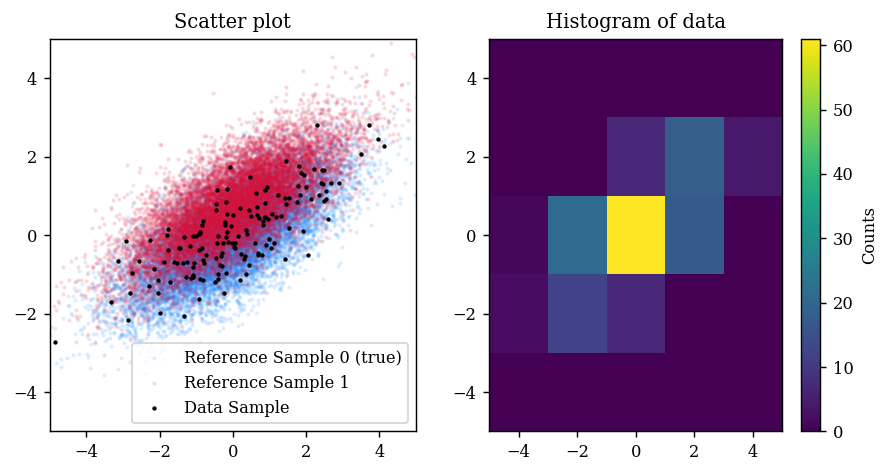

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(reference_sample_0.T[0], reference_sample_0.T[1], s=2, 
                c='dodgerblue', alpha=.1, label='Reference Sample 0 (true)')
axes[0].scatter(reference_sample_1.T[0], reference_sample_1.T[1], s=2,
                c='crimson', alpha=.1, label='Reference Sample 1')
axes[0].scatter(data_sample.T[0], data_sample.T[1], s=2, c='k', 
                label='Data Sample')

h = axes[1].hist2d(data_sample.T[0], data_sample.T[1], bins=bin_edges)
fig.colorbar(h[3], ax=axes[1], label='Counts')
axes[0].legend()
axes[0].set_title('Scatter plot')
axes[1].set_title('Histogram of data')

for ax in axes:
    ax.set_xlim(bin_edges[0].min(), bin_edges[0].max())
    ax.set_ylim(bin_edges[1].min(), bin_edges[1].max())

plt.show()

## 1. Make a simple GOF test

There are multiple ways to initialize a GOF test depending on the kind of data that you want to use as an input. A few options are shown in the next few cells. All of them have in common that they create an instance of a class corresponding to the respective GOF test.  
For all of these instances the methods `.get_gof()` and `.get_pvalue()` can then be used to calculate the test statistic and p-value of the test.

### 1.1 Regular init

**For binned tests:** initialize with data sample, bin edges and binned PDF, the data sample is then binned internally.

In [5]:
gof_object = ge.BinnedPoissonChi2GOF(data_sample=data_sample, 
                                     pdf=pdf_0, 
                                     bin_edges=bin_edges, 
                                     nevents_expected=n_expectations)
gof = gof_object.get_gof()
pval = gof_object.get_pvalue()
print(f'GOF = {gof:.2f}')
print(f'p = {pval:.2f}')

/home/hammann/GOFevaluation/GOFevaluation/evaluators_nd.py:86: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  gof = self.calculate_gof(self.binned_data, self.binned_reference)
/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:147: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  fake_gofs[i] = self.calculate_gof(


GOF = 230.58
p = 0.00


/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:184: UserWarning: p-value is 0.0. (Observed GoF: 2.31e+02, maximum of simulated GoFs: 3.48e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)


The problem with this test is that the regular binning causes expectation values in the bins that range over multiple orders of magnitude. This makes the GOF test unstable, a better option is to use an equiprobable binning (See 1.3)

**For unbinned tests:** initialize with data sample, bin edges and binned PDF, the data sample is then binned internally.

In [6]:
# perform a 1D test here:
gof_object = ge.ADTestTwoSampleGOF(data_sample=data_sample.T[1],
                                reference_sample=reference_sample_0.T[1])

gof = gof_object.get_gof()
pval = gof_object.get_pvalue()
print('Reference 0 (y-coordinate)')
print(f'GOF = {gof:.2f}')
print(f'p = {pval:.2f}')
print()

gof_object = ge.ADTestTwoSampleGOF(data_sample=data_sample.T[1],
                                reference_sample=reference_sample_1.T[1])

gof = gof_object.get_gof()
pval = gof_object.get_pvalue()
print('Reference 1 (y-coordinate)')
print(f'GOF = {gof:.2f}')
print(f'p = {pval:.2f}')

Reference 0 (y-coordinate)
GOF = -0.60
p = 0.71

Reference 1 (y-coordinate)
GOF = 39.87
p = 0.00


/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:297: UserWarning: p-value is 0.0. (Observed GoF: 3.99e+01, maximum of simulated GoFs: 6.72e+00). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_perm=n_perm, d_min=d_min)


### 1.2 Initialize with binned data

For binned GOF tests, if the data is already inbinned format:

In [7]:
gof_object = ge.BinnedPoissonChi2GOF.from_binned(binned_data=binned_data, 
                                                 binned_reference=expectations_0)
gof = gof_object.get_gof()
pval = gof_object.get_pvalue()
print(f'GOF = {gof:.2f}')
print(f'p = {pval:.2f}')

/home/hammann/GOFevaluation/GOFevaluation/evaluators_nd.py:86: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  gof = self.calculate_gof(self.binned_data, self.binned_reference)
/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:147: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  fake_gofs[i] = self.calculate_gof(


GOF = 230.58
p = 0.00


/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:184: UserWarning: p-value is 0.0. (Observed GoF: 2.31e+02, maximum of simulated GoFs: 3.14e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)


Note that this is exactly the same result that we got from the regular initailization!

### 1.3 Equiprobable Binning

with the initialisation `.bin_equiprobable()`, the data is binned such that the expectation value in each bin is the same. With the visual represantation one can see quite easily where the data exceeds the expectation and in which region it shows fewer events than predicted under the null hypothesis.

Reference 0: p=0.96


/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:184: UserWarning: p-value is 0.0. (Observed GoF: 1.33e+02, maximum of simulated GoFs: 6.44e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)


Reference 1: p=0.00


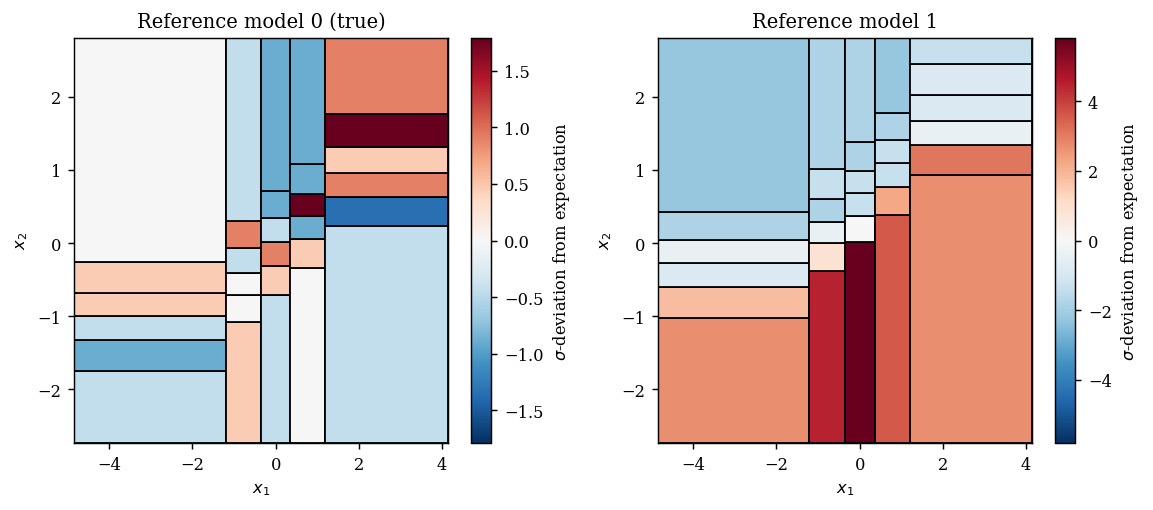

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# define eqpb parameters
order = [0, 1]  # [0, 1] means that first dimension 0 is binned, then dimension 1
n_partitions = [5, 6]  # 5 partitions in dim. 0 and 6 partitions in dim. 1

# perform GOF tests
gof_object = ge.BinnedPoissonChi2GOF.bin_equiprobable(data_sample=data_sample,
                                                      reference_sample=reference_sample_0,
                                                      nevents_expected=n_expectations,
                                                      n_partitions=n_partitions,
                                                      order=order,
                                                      plot=True,
                                                      ax=axes[0]
                                                     )
pvalue_0 = gof_object.get_pvalue()
print(f'Reference 0: p={pvalue_0:.2f}')

gof_object = ge.BinnedPoissonChi2GOF.bin_equiprobable(data_sample=data_sample,
                                                      reference_sample=reference_sample_1,
                                                      nevents_expected=n_expectations,
                                                      n_partitions=n_partitions,
                                                      order=order,
                                                      plot=True,
                                                      ax=axes[1]
                                                     )
pvalue_1 = gof_object.get_pvalue()
print(f'Reference 1: p={pvalue_1:.2f}')
axes[0].set_title('Reference model 0 (true)')
axes[1].set_title('Reference model 1')

for ax in axes:
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
plt.tight_layout()

## 2. Perform multiple GOF tests at once

In [9]:
# Initialise all binned GOF measures (with equiprobable binning):
gof_object = ge.GOFTest(data_sample=data_sample, 
                        reference_sample=reference_sample_0,
                        nevents_expected=n_expectations,
                        n_partitions=[5, 6],
                        gof_list=['BinnedChi2GOF.bin_equiprobable', 
                                  'BinnedPoissonChi2GOF.bin_equiprobable'])
gof_object.get_gofs()
gof_object.get_pvalues()
print(gof_object)

GOFevaluation.gof_test
GoF measures: BinnedChi2GOF.bin_equiprobable, BinnedPoissonChi2GOF.bin_equiprobable
gofs = 18.8, 18.57899301976094
p-values = 0.952, 0.964
